# Overview

This is a notebook meant to introduce some of the practical low-level parts of running the pipeline being built in simons_array_offline_software here: https://bitbucket.org/berkeleylab/simons_array_offline_software/src/master/

If you would like to clone the repository to begin contributing, please contact myself at (ktc35@berkeley.edu) and Yuji Chinone at (chinoney@cmb.phys.s.u-tokyo.ac.jp). You will need an active bitbucket account.

## Accessing the code

Once you have access via a bitbucket account, you can run:

> git clone https://(user_name)@bitbucket.org/berkeleylab/simons_array_offline_software.git

to download a working copy of the repository. We don't yet have hard-and-fast rules on adding commits directly to master vs. branching, but any substantial changes to the main modules in the code (which we will discuss) should get a new branch.

Once you have the code, please run setup.py under the newly-created directory simons_array_offline_software. This will create a .py file called sa_config.py under simons_array_offline_software/simons_array_python, which the pipeline needs to know where to look for metadata databases, data files, etc. **This will likely only be useful on the Berkeley analysis machine tostada1 -- tostada1.physics.berkeley.edu**. That means you'll need an account on that machine as well.

An additional point: currently the module import statements work with the following additional paths added to your PYTHONPATH environment variable (on tostada, for instance):

/home/(tostada_user_name)/simons_array_offline_software

/home/(tostada_user_name)/simons_array_offline_software/kms_git/kms_plot

You can add these to your .bashrc file, which is loaded on log-in to tostada, with the following command:

> export PYTHONPATH=$PYTHONPATH:/home/(tostada_user_name)/simons_array_offline_software:/home/(tostada_user_name)/simons_array_offline_software/kms_git/kms_plot

You will also likely find it convenient to run the setup.sh script that loads the TOAST libraries of CMB data analysis code into your working session. Do this with the following lines in your .bashrc:

> . /opt/toast/deps/latest/setup.sh

> . /opt/toast/latest/setup.sh

As a help, the file "bashrc_additions.txt" in the "2020_s2s" bitbucket repository has these commands.

## Overview of pipeline modules

With the software installed, you're ready to start running pipeline code!

The basic structure of the pipeline is as follows:

 - Observations are the base unit. They contain metadata, time-ordered data, and various outputs of processing.
 - Operators act on observations. They load data, perform analyses, and save the outputs.
 - TODs are added as lists to Observations by particular Operators. They contain all data loaded from disk (g3 file and slowdaq file). They also act as a cache for loaded data, and can be directed to load additional detector data from disk, 
 
The Observation class is defined in simons_array_python/sa_observation.py (all main modules live in this folder). We identify observations by their **run_id** and **run_subid**, as a Python tuple usually. Operators are defined in a few places (sa_digest_source.py, sa_timestream_operators.py, sa_cuts.py) but mostly in sa_pipeline_filters.py. Special objects used to create OperatorDataInitializer objects are defined in sa_pipeline_inputs.py.

As a warning, there are currently a few modules which are holdovers from pipelines from earlier experiments (sa_datafile, sa_ces, etc.). These are not useful for SA 

### Data access examples

Below are some cells which demonstrate how to load data from disk into a list of TOD objects that is an attribute of an Observation object.

In [1]:
# import statements to pipeline modules
import simons_array_python.sa_observation as sa_ob
import simons_array_python.sa_pipeline_filters as sa_pf
import simons_array_python.sa_pipeline_inputs as sa_pi

INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_focalplane.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_scan_stat.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_tuning.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_slowdaq.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_hardware_map.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20200818/pb2a_monitor.db attached.
INFO: numpy.fft used.


In [2]:
# make observation, load metadata from the SQL dbs attached above
ob = sa_ob.Observation((20100544,9)) # moon scan
ob.load_metadata()
print(ob.first_mjd, ob.last_mjd) # from pb2a_runid.db

Reading SQL table pb2a_runid...

58615.04876826961 58615.08129586864


done.


In [3]:
# Check the argument structure
sa_pi.InputLevel0CachedByObsID?

In [4]:
# make pipeline input object from sa_pi
## NOTE: all_detectors is an argument to specify the possible set of detectors to be loaded later. 
## we dummy it with an empty list for now
pi = sa_pi.InputLevel0CachedByObsID(all_detectors=[], n_per_cache=30, load_g3=True, load_gcp=True,
                                    load_slowdaq=False, load_hwp=False, load_dets=False, ignore_faulty_frame=True)

# create data_initalizer operator to load this data
op_dataload = sa_pf.OperatorDataInitializer(pi)

In [5]:
# Run simple dataload, and make a plot
# Every Operator in the pipeline defines a filter_obs method, which is used to act 
# on the TODs associated with that observation one by one
op_dataload.filter_obs(ob)

INFO: instantiating g3 data buffer from None
INFO: Run20100544.9: reading following files: Run20100544_000.g3,Run20100544_001.g3,Run20100544_002.g3,Run20100544_003.g3,Run20100544_004.g3,Run20100544_005.g3,Run20100544_006.g3,Run20100544_007.g3,Run20100544_008.g3,Run20100544_009.g3.
INFO: Run20100544.9: frame (total, first, last)=(1280, 49, 1276).


Loading data from g3 files for run_id=20100544, run_subid=9 . . . 
Reading SQL table pb2a_runid_g3file...done.
Reading SQL table pb2a_g3file...done.


Setting input name to data
[]


In [6]:
# Load plotting tools
%matplotlib inline
import matplotlib.pylab as pl
import numpy as np

dict_keys(['frame_faulty', 'frame_total', 'input_name', 'raw_acu_seq', 'raw_az_pos', 'raw_az_command', 'raw_az_rate', 'raw_az_rate_command', 'raw_el_pos', 'raw_el_command', 'raw_el_rate', 'raw_el_rate_command', 'raw_in_control', 'raw_scan_flag', 'raw_state', 'raw_antenna_time_mjd', 'frame_antenna_time_mjd'])


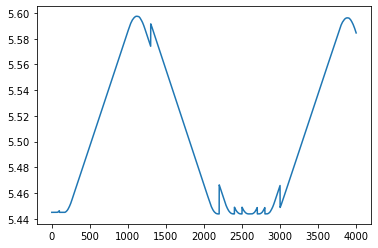

In [7]:
# Test plot of azimuth position in newly populated TOD

print(ob.tod_list[0].cache.keys()) # The TOD loaded from disk lives as the first and only object in the tod_list attribute

azvec = ob.tod_list[0].read('raw_az_pos')

pl.plot(azvec[2000:6000]) # This is near a turnaround -- what are those weird spikes??

In [8]:
# Let's remake our observation cleanly, then act on it with the OperatorScanCorrector

ob2 = sa_ob.Observation((20100544,9)) # moon scan
ob2.load_metadata()

pi2 = sa_pi.InputLevel0CachedByObsID(all_detectors=[], n_per_cache=30, load_g3=True, load_gcp=True,
                                    load_slowdaq=False, load_hwp=False, load_dets=False, ignore_faulty_frame=True)

# alternately, begin making composite operator to load data, then do processing to remove repeated samples at G3 frame boundaries
# the operators will be run sequentially from bottom to top (i.e. right to left, rightmost operator acting on obs first)
op_preprocess = sa_pf.OperatorComposite(
    sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_scan_flag', 'raw_antenna_time_mjd'),
    sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_el_pos', 'raw_antenna_time_mjd'),
    sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_az_pos', 'raw_antenna_time_mjd'),
    sa_pf.OperatorDataInitializer(pi2))

op_preprocess.filter_obs(ob2)

INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorDataInitializer'>
Loading data from g3 files for run_id=20100544, run_subid=9 . . . 


INFO: instantiating g3 data buffer from None
INFO: Run20100544.9: reading following files: Run20100544_000.g3,Run20100544_001.g3,Run20100544_002.g3,Run20100544_003.g3,Run20100544_004.g3,Run20100544_005.g3,Run20100544_006.g3,Run20100544_007.g3,Run20100544_008.g3,Run20100544_009.g3.
INFO: Run20100544.9: frame (total, first, last)=(1280, 49, 1276).
Setting input name to data
[]


INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>


NEW VECTOR LENGTHS! 370400 282700
NEW VECTOR LENGTHS! 370400 282700
NEW VECTOR LENGTHS! 370400 282700


INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>


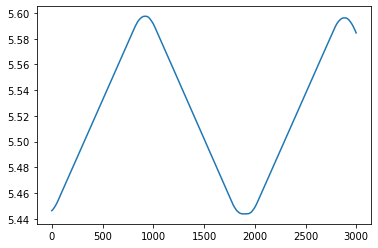

In [9]:
azvec = ob2.tod_list[0].read('corrected_az_pos')

pl.plot(azvec[2000:5000])

In [10]:
# Congrats! We have now loaded data, and manipulated it (to remove unwanted repeat data in the azimuth position timestream)
# Many other operators have been developed; as another example, here is one that produces timestream statistics
from simons_array_python.sa_digest_source import OperatorDigestSource
from simons_array_python.sa_scan_reduction import mean_deg, median_deg, minmax_deg

op_digest_az = OperatorDigestSource('corrected_az_pos', mean=mean_deg, median=median_deg, minmax=minmax_deg)
op_digest_az.filter_obs(ob2)
print(getattr(ob2.tod_list[0], 'digest_parameter_results')) # new TOD attribute, not in TOD.cache

DIGEST DATA SHAPE corrected_az_pos (282700,)
digest_parameter_results
[('corrected_az_pos', 'mean', 311.5260481953055), ('corrected_az_pos', 'median', 311.56918767010325), ('corrected_az_pos', 'minmax', 17.83851433834902)]


INFO: Applying pipeline filter: <class 'simons_array_python.sa_cuts.OperatorSubscanRange'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_pointing.ComputeBoresightEquatorialCoordinates'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_scan_reduction.OperatorRaDecPlot'>


INFO: loading precomputed subscan ranges from TOD cache
140311 140311 140311


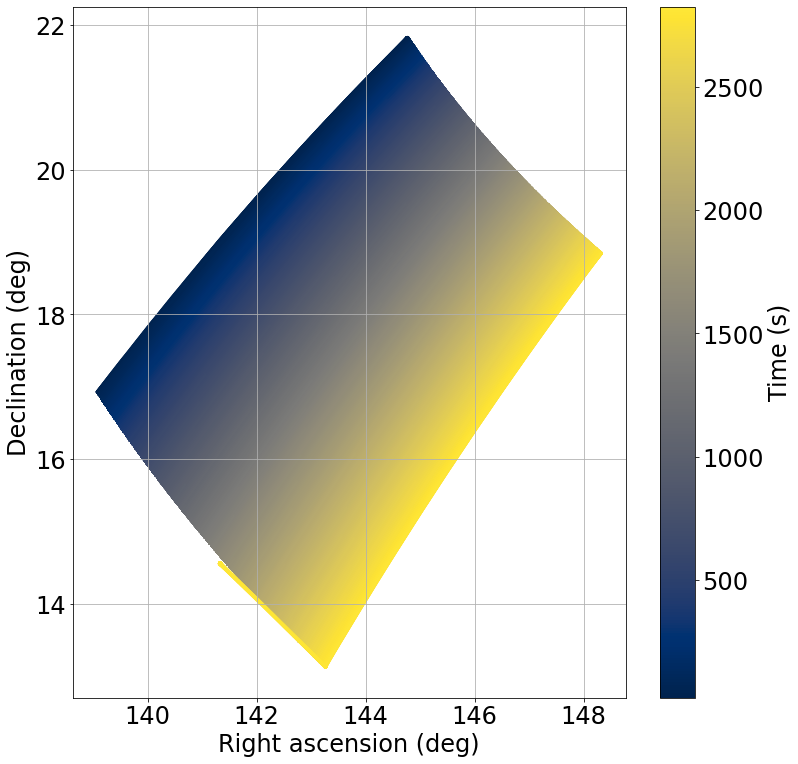

In [11]:
# As a final example, here's a set of two operators that can be used to make a plot of the boresight pointing vs. time in RA,DEC
from simons_array_python.sa_cuts import OperatorSubscanRange
from simons_array_python.sa_pointing import ComputeBoresightEquatorialCoordinates
import simons_array_python.sa_scan_reduction as sa_sr

import imp
imp.reload(sa_sr)

op_make_boresight = sa_pf.OperatorComposite(
    sa_sr.OperatorRaDecPlot(plot_file_factory='', step_interval=2),
    ComputeBoresightEquatorialCoordinates(prefix='corrected_'),
    OperatorSubscanRange(az_field_name='corrected_az_pos', prefix='corrected_', plot=False, force=False))

op_make_boresight.filter_obs(ob2)

## Contributing to the pipeline
A list of tasks to be worked on to improve the pipeline is here: https://docs.google.com/spreadsheets/d/1vQJ5l0NUBgH7Ako0OHnCK5Awo0LBjdXrfy3sEgzpDT8/edit?usp=sharing

Please take a look, volunteer yourself for a task that interests you, and be sure to reach out on the following Slack channels on the Polarbear Slack for troubleshooting, questions, brainstorming, and all other communications!
#sa_pipeline_devel
#sa-pipe_bolo-proc
#sa-pipe_database
#sa-pipe_scan_proc
#sa-pipe_sims
#sa-pipe_slow_proc